# Multi Layer Perceptron
This notebook will build and train a multilayer perceptron (MLP) from scratch with minimal reliance upon libraries. The MLP will be trained on the popular iris dataset. 

### Load Libraries and Split Data
The data used will be split using an 80/20 ratio of training to testing data.

In [67]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
data = load_iris(as_frame=True)
data.frame.head()

# Perform 80/20 split for test and train
x_train, x_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.2, random_state=0xdeadbeef)

### Activation Functions
As part of this journal I will investigate a series of activation functions that could be acceptable choices for an MLP implementation. I will investigate and assess the hyperbolic tan function, sigmoid function, and leaky ReLU function.

In [69]:
def activate_hyperbolic(x):
    '''
    Hyperbolic tangent activation function
    Args:
     - x: input tensor
    Returns:
     - activated tensor
    '''
    return tf.tanh(x)

def activate_sigmoid(x):
    return 1 / (1 + np.exp(-x) + tf.keras.backend.epsilon())

def activate_lrelu(x, leak_factor=0.01):
    return tf.maximum(x, leak_factor * x)

def lrelu_derivative(x, leak_factor=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = leak_factor
    return dx

def sigmoid_derivative(x):
    return activate_sigmoid(x) * (1 - activate_sigmoid(x))

def hyperbolic_derivative(x):
    return 1 - tf.square(tf.tanh(x))

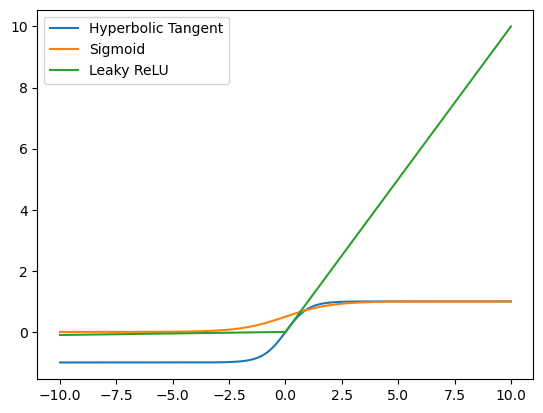

In [70]:
test_data = np.linspace(-10, 10, 1000)

# Plot the activation functions
import matplotlib.pyplot as plt

plt.plot(test_data, activate_hyperbolic(test_data), label='Hyperbolic Tangent')
plt.plot(test_data, activate_sigmoid(test_data), label='Sigmoid')
plt.plot(test_data, activate_lrelu(test_data), label='Leaky ReLU')
plt.legend()

In [ ]:
class MultiLayerPerceptron():
    def __init__(self, activation_func=activate_hyperbolic, derivative_func=hyperbolic_derivative):
        self.activation_func = activation_func
        self.derivative_func = derivative_func

    def build(self, input_size, hidden_size, output_size):
        pass


    def fit(self, x_train, y_train, x_test, y_test, epochs=100, learning_rate=0.01):
        pass
